In [1]:
import sys
sys.path.append('../../..')

from olfactory_navigation import Environment
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.simulation import run_test, SimulationHistory
from olfactory_navigation.test_setups import run_all_starts_test

from olfactory_navigation.agents.model_based_util.belief import Belief, BeliefSet

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import cupy as cp

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(2)

## Parameters

In [3]:
tank_size = np.array([111,142]) # actual size: 114cm x 89cm but it is scaled by a walking speed of 0.8 cm/s
space_shape = (tank_size * 2) + 1

goal_radius = 1
# odor_radius = 10.5
odor_radius = 3.75 # 3 cm * 0.8 -> 3.75 grid units

In [4]:
odor_field = np.zeros(space_shape)
odor_field_indices = np.array(list(np.ndindex(tuple(space_shape))))

in_odor_plume = np.sum((odor_field_indices - tank_size[None,:])**2, axis=1) <= (odor_radius ** 2)
odor_field[*odor_field_indices[in_odor_plume].T] = 1.0

## Building model

In [5]:
env = Environment(data_file=odor_field[None,:,:],
                  data_source_position=tank_size,
                  source_radius=goal_radius,
                  boundary_condition='wrap')

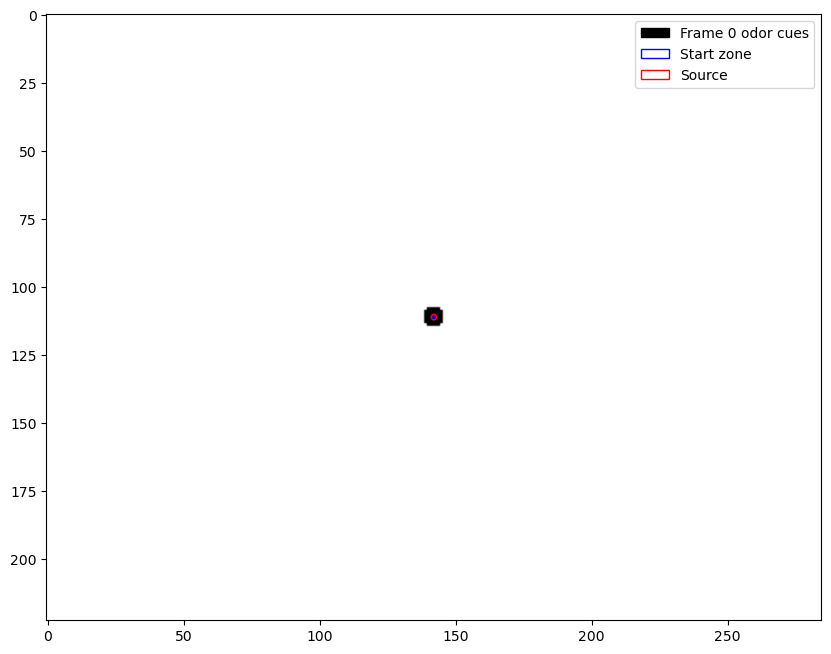

In [6]:
_,ax = plt.subplots(1,1, figsize=(10,10))
env.plot(ax=ax)

## Agent Training

In [7]:
ag = FSVI_Agent(env)

In [8]:
_ = ag.train(expansions=800,
             max_belief_growth=100,
             eps=1e-8,
             use_gpu=True)

[11/12/2024, 23:03:40] MDP_policy, not provided. Solving MDP with Value Iteration...
[11/12/2024, 23:03:40] Sending Model to GPU...
[11/12/2024, 23:03:40]     > Done in 0.240s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 63555-state, 4-action
  - Converged in 1000 iterations and 1.4393 seconds
  - Took on average 0.0014s per iteration


Expansions:   0%|          | 0/800 [00:00<?, ?it/s]

Memory full: Out of memory allocating 14,905,427,456 bytes (allocated so far: 66,394,701,312 bytes).
Returning value function and history as is...

Summary of Point Based Value Iteration run
  - Model: 63555 state, 4 action, 3 observations
  - Converged or stopped after 458 expansion steps and 457 backup steps.
  - Resulting value function has 2443 alpha vectors.
  - Converged in 277.7890s

  - Expand function took on average 0.1475s and yielded on average 5983.54 beliefs per iteration. (0.0001s/it/belief)
  - Backup function took on average 0.4600s and yielded on average 5.34 alpha vectors per iteration. (0.0007s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


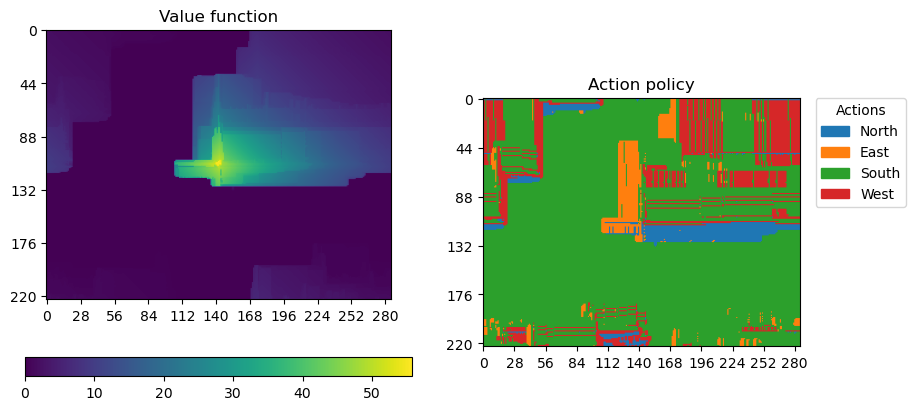

In [9]:
ag.value_function.plot()

## Run test

### Single point

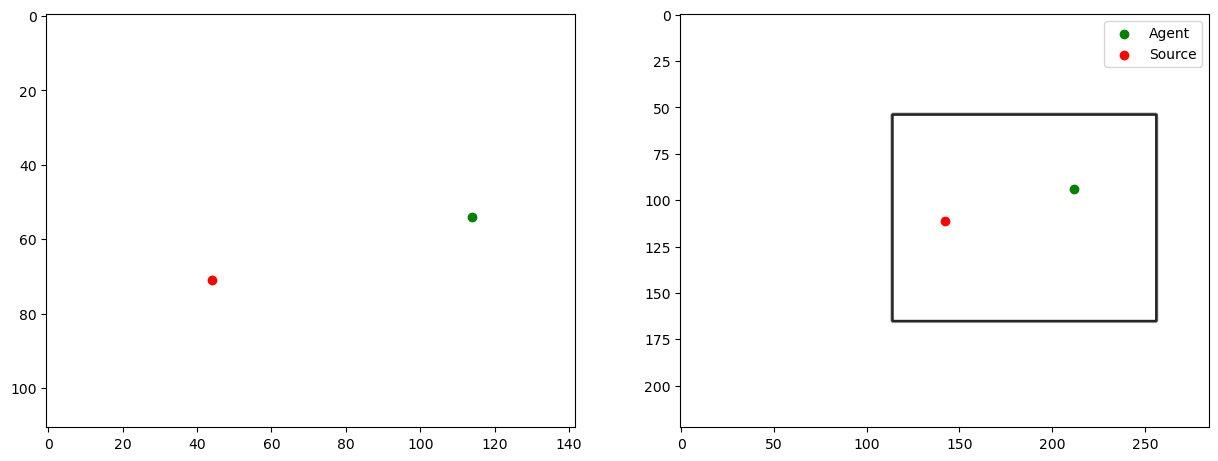

In [11]:
# PHYSICAL SPACE
source_point = (np.random.random(2) * tank_size).astype(int)
agent_start = (np.random.random(2) * tank_size).astype(int)

fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(15,10))

ax0.imshow(np.zeros(tank_size), cmap='Greys')
ax0.scatter(source_point[1], source_point[0], c='red', label='Source')
ax0.scatter(agent_start[1], agent_start[0], c='green', label='Agent')

# STATE SPACE
center_state = agent_start
agent_start_state = center_state + (tank_size - source_point)

belief = np.zeros(space_shape)
belief[center_state[0]:center_state[0]+tank_size[0]+1, center_state[1]:center_state[1]+tank_size[1]+1] = 1
belief /= np.sum(belief)

ax1.imshow(np.zeros(space_shape), cmap='Greys')
ax1.contour(belief, cmap='Greys')
# ax1.invert_yaxis()
ax1.scatter(agent_start_state[1], agent_start_state[0], c='green', label='Agent')
ax1.scatter(tank_size[1], tank_size[0], c='red', label='Source')
ax1.legend()

In [12]:
belief = BeliefSet(model=ag.model, beliefs=[Belief(model=ag.model, values=belief.ravel())])
hist = run_test(agent=ag,
                start_points=agent_start_state[None,:],
                initialization_values={'belief': belief},
                use_gpu=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 7.639s:
Simulations reached goal: 0/1 (1 failures (reached horizon: 1)) (0.00% success)


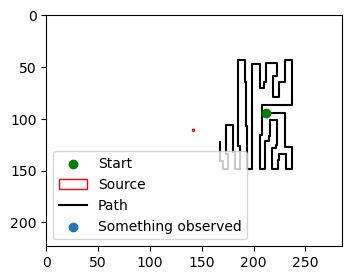

In [13]:
hist.plot()

In [26]:
69714246144 / 1024**2

66484.68603515625